# Section 1: Predicting Parkinson's from speech in Python
This work-along demonstrates how Parkinson's can be predicted from speech patterns using statistics and machine learning in Python.
It uses [this](https://archive.ics.uci.edu/ml/datasets/parkinsons) dataset. 
The authors have kindly extract some information from spoken interviews of participants.
We will get started right away by taking a look what kind of information we have!

If you have not worked with Jupyter notebooks before, take a look [here](https://realpython.com/jupyter-notebook-introduction/) for information on how to use them.

In [1]:
# Download the data
!curl -o "parkinsons.csv" https://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/parkinsons.data

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 40697  100 40697    0     0  39278      0  0:00:01  0:00:01 --:--:-- 39358


# Section 2. First Glances

In [2]:
# Load in libraries that we will use throughout this work-along
# Don't worry too much about what exactly these libraries are,
# we will see them in action later
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef, ConfusionMatrixDisplay

mpl.rcParams["figure.dpi"] = 150

In [3]:
# Load in data 
data = pd.read_csv("./parkinsons.csv")

# Print the first 5 rows of the data
data.head()

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


We see there are 24 columns in the data. Whether a participant was diagnosed with Parkinson's or not is denoted by the column "status". A value of 1 or 0 denote that a participant did or did not have Parkinson's, respectively. 

This means that this challenge will be a classification challenge. Classification means that we have discrete classes, in this case two, that we are aiming to predict. Alternatively, problems can be regression challenges, where the aim is to predict a continuous outcome, like litres of gas a car uses.

Here's a quick intro as to what each column contains:

- name - ASCII subject name and recording number
- MDVP:Fo(Hz) - Average vocal fundamental frequency
- MDVP:Fhi(Hz) - Maximum vocal fundamental frequency
- MDVP:Flo(Hz) - Minimum vocal fundamental frequency
- MDVP:Jitter(%), MDVP:Jitter(Abs), MDVP:RAP, MDVP:PPQ, Jitter:DDP - Several measures of variation in fundamental frequency
- MDVP:Shimmer, MDVP:Shimmer(dB), Shimmer:APQ3, Shimmer:APQ5,MDVP:APQ, Shimmer:DDA - Several measures of variation - in amplitude
- NHR, HNR - Two measures of ratio of noise to tonal components in the voice
- status - Health status of the subject (one) - Parkinson's, (zero) - healthy
- RPDE, D2 - Two nonlinear dynamical complexity measures
- DFA - Signal fractal scaling exponent
- spread1, spread2, PPE - Three nonlinear measures of fundamental frequency variation


Next, let's see how many participants did or did not have Parkinson's.

In [4]:
data["status"].value_counts()

1    147
0     48
Name: status, dtype: int64

That means 147 and 48 participants did and did not have Parkinson's (1's and 0' in the "status" column, respectively). Note: as a rule of thumb it is better to train on "balanced" datasets, i.e. data where we have an equal number of observations per class. You can read more about the reasons for this [here](https://machinelearningmastery.com/what-is-imbalanced-classification/).

# Section 3: Data splits
We would like to split our data into train and test datasets so that we can evaluate the performance of our model on data that it has not seen before. If we use all of our data to train our model, it may overfit to the training data, meaning that it will perform well on the data it has seen, but poorly on new, unseen data. By holding out a portion of our data for testing, we can evaluate how well our model generalizes to new data. This allows us to assess the real-world performance of our model, and make any necessary adjustments before deploying it in practice.

In [5]:
# Remove the "status" column from the features and store it in the target variable

# We will store variables used for prediction in "X" and the status of people (healthy, Parkinson's) in "y"
X = data.drop(['status',"name"], axis=1) # a dataframe of all variables we want to use to predict Parkinson's
y = data['status'] # contains 1s and 0s

# Split the data into training and testing sets
# We will use 70% of the data for training and 30% for testing (evaluating) our model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

# How many rows and columns are in the training and testing data?
print(f"Training Data Shape: {X_train.shape}")
print(f"Training Labels Shape: {y_train.shape}")

print(f"Testing Data Shape: {X_test.shape}")
print(f"Testing Labels Shape: {y_test.shape}")

Training Data Shape: (136, 22)
Training Labels Shape: (136,)
Testing Data Shape: (59, 22)
Testing Labels Shape: (59,)


# Section 4: Exploring individual features
Now that we have split our data into training and testing sets, let's take a closer look at some of the individual features to see if they might be good predictors of Parkinson's disease. One way to do this is to create scatter plots of each feature versus the outcome (whether or not a participant has Parkinson's).

Let's start by looking at three features: "MDVP:Fo(Hz)", "MDVP:Jitter(%)", and "MDVP:Shimmer". We can create scatter plots of these features versus the outcome using Matplotlib:

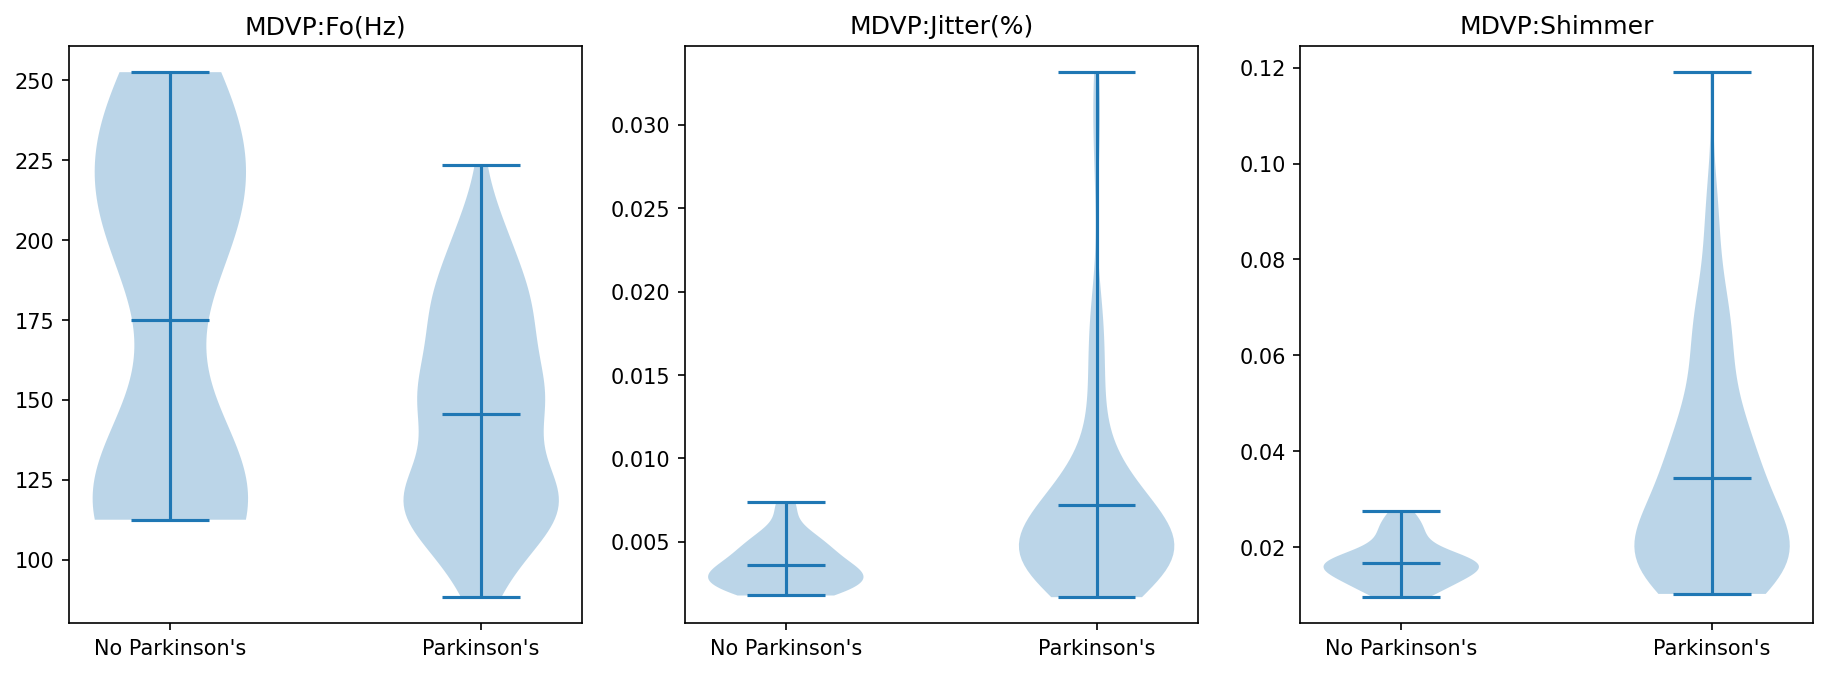

In [6]:
# create violin plots for three features
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

# We use enumerate here to loop over these three features and plot the one-by-one
for idx, feature in enumerate(["MDVP:Fo(Hz)", "MDVP:Jitter(%)", "MDVP:Shimmer"]):
    ax = axes[idx]
    # Plot a violin plot
    ax.violinplot([X_train[y_train==0][feature], X_train[y_train==1][feature]], showmeans=True)
    ax.set_xticks([1, 2])
    ax.set_xticklabels(["No Parkinson's", "Parkinson's"])
    ax.set_title(feature)
    
plt.show()

Looking at the violin plots we just created, we can see that there appears to be some discrimination between the two classes in each of the three features we plotted. For example, for the "MDVP:Fo(Hz)" feature, we can see that the distribution of values for participants with Parkinson's (right) is shifted towards lower values compared to the distribution for other participants (left). The opposite is true, to varying degrees, for the other two features we plotted, "MDVP:Jitter(%)" and "MDVP:Shimmer".

This is encouraging, as it suggests that these features may be useful for our classification task later on. When we train a machine learning model to predict whether or not a participant has Parkinson's, it may be able to make use of these differences in feature values to accurately classify new, unseen participants. However, we will need to do more analysis to confirm whether or not these features are truly predictive of Parkinson's status.

Note that we are only using the training data to create these plots, not the test data. This is because we don't want to introduce any bias into our model by using information from the test set before we've made our final predictions.

Thought experiment for those with time: do you think these differences are caused by Parkinson's? Why or why not?

# Section 5: Correlating features with Parkinson's
We can also explore how each feature is correlated with our outcome variable, "status". One way to do this is by calculating Pearson's correlation coefficient between each feature and the outcome. The Pearson correlation coefficient measures the linear correlation between two variables, with values ranging from -1 (perfect negative correlation) to 1 (perfect positive correlation), with 0 indicating no correlation.

This will print out the correlation coefficients between each feature and the "status" variable. Positive values indicate a positive correlation (as one variable increases, so does the other), while negative values indicate a negative correlation (as one variable increases, the other decreases).

Note that correlation does not imply causation, and high correlation between a feature and the outcome does not necessarily mean that the feature is a good predictor of the outcome. We will explore this more in the next section, where we will use machine learning algorithms to predict Parkinson's disease from speech features.

In [7]:
corr_matrix = X_train.corrwith(y_train)
print(corr_matrix)

MDVP:Fo(Hz)        -0.314974
MDVP:Fhi(Hz)       -0.197335
MDVP:Flo(Hz)       -0.368569
MDVP:Jitter(%)      0.281036
MDVP:Jitter(Abs)    0.322513
MDVP:RAP            0.273712
MDVP:PPQ            0.292515
Jitter:DDP          0.273727
MDVP:Shimmer        0.367830
MDVP:Shimmer(dB)    0.354086
Shimmer:APQ3        0.353820
Shimmer:APQ5        0.357580
MDVP:APQ            0.355298
Shimmer:DDA         0.353805
NHR                 0.210522
HNR                -0.386520
RPDE                0.239621
DFA                 0.232219
spread1             0.531063
spread2             0.417997
D2                  0.431380
PPE                 0.505530
dtype: float64


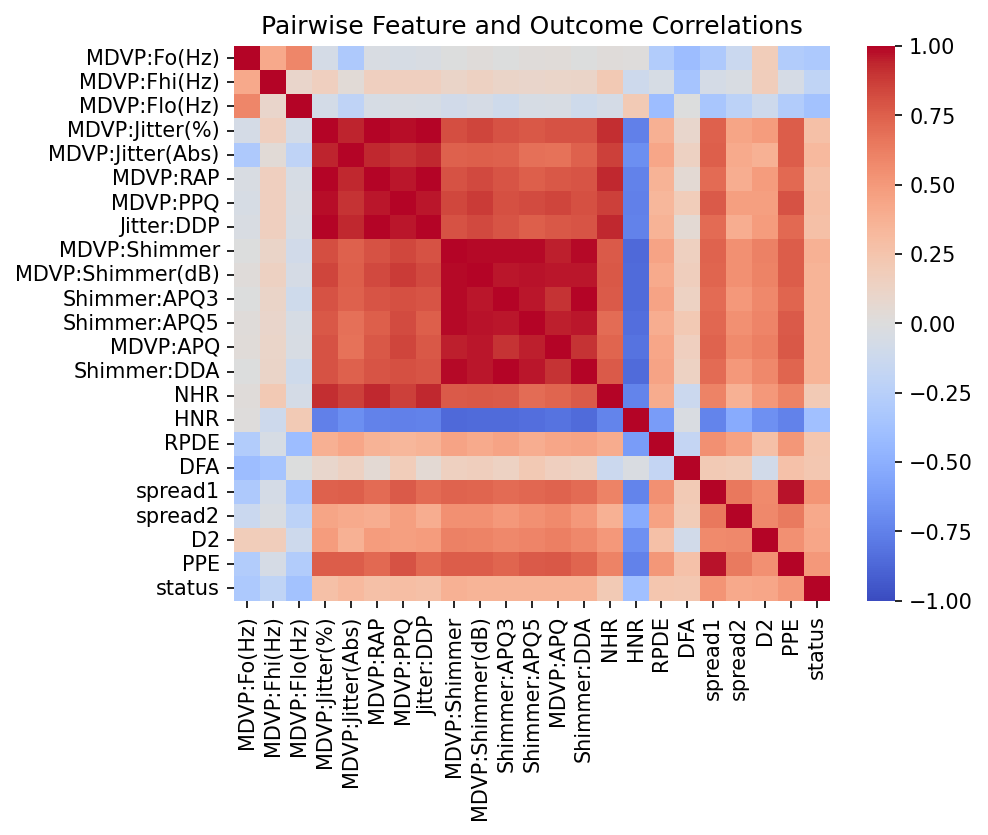

In [8]:
# Combine X_train and y_train into a single dataframe
train_df = pd.concat([X_train, y_train], axis=1)

# Compute the pairwise correlations between all columns
corr_matrix = train_df.corr()

# Create a heatmap of the correlations
sns.heatmap(corr_matrix, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Pairwise Feature and Outcome Correlations")
plt.show()

# Section 6: Building a first model
Machine learning is a powerful tool for solving classification and regression problems like predicting Parkinson's from speech patterns. With machine learning, we can train a model on a subset of our data and then use it to predict the outcome of unseen data.

In this work-along, we will be using a supervised learning approach, where we have labeled data (i.e., the outcome variable is known for all observations). Specifically, we will use logistic regression to predict whether a participant has Parkinson's or not based on their speech patterns. We will use the scikit-learn (sklearn) library in Python, which is a popular machine learning library with a wide range of algorithms and tools for model training and evaluation.

To train our logistic regression model, we will use the training set that we created earlier, which is a subset of our data. We will fit the model to the training data, and then use it to predict the outcome for the test data. Finally, we will evaluate the performance of our model to see how well it is performing.

In [9]:
# Create an instance of the LogisticRegression class
model = LogisticRegression(max_iter=1000)

# Fit the model to the training data
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

# Section 7: Evaluating our model
Model evaluation is an essential part of machine learning as it helps us understand how well our model is performing on the data. It is crucial to evaluate the model's performance before deploying it in a real-world scenario to avoid making any critical mistakes. Keep in mind that, because we are using logistic regression the model can produce probabilities - i.e. for each participant it will give two probabilities: the patient being healthy and the patient having Parkinson's.
We can see these predictions like so:

In [10]:
# Predict probabilities for the test data
y_prob_pred = model.predict_proba(X_test) * 100

# Predict labels using a 50% threshold
y_pred = model.predict(X_test)

# Format the predictions into a dataframe
y_prob_pred_df = pd.DataFrame(y_prob_pred, 
                              columns=["% No Parkinson's", "% Parkinson's"], 
                              index=y_test.index)

y_prob_pred_df.insert(2, "Predicted", y_pred)

y_prob_pred_df.insert(0, "Actual", y_test)
y_prob_pred_df.groupby("Actual").head(5)

,Actual,% No Parkinson's,% Parkinson's,Predicted
138,1,5.286015,94.713985,1
16,1,18.979304,81.020696,1
155,1,0.390862,99.609138,1
96,1,22.941163,77.058837,1
68,1,14.941908,85.058092,1
184,0,10.083344,89.916656,1
192,0,27.746480,72.253520,1
45,0,75.236085,24.763915,0
30,0,90.189269,9.810731,0
172,0,25.147457,74.852543,1


We can spot a few things right away: the model seems to predict Parkinson's patients well - the probability that a patient with Parkinson's ("Actual" = 1) is predicted to have Parkinson's is usually high.
Vice versa, sometimes the model will classify healthy patients ("Actual = 0") as having Parkinson's.

We can evaluate this things numerically to get actual metrics to compare different models.
Let's look at some basic metrics first: how often did our model predict disease/healthy correctly or incorrectly?


In [11]:
# Use the trained model to make predictions on the test data
y_pred = model.predict(X_test)

TP = sum(y_pred[y_test == 1] == 1)
FP = sum(y_pred[y_test == 0] == 1)
TN = sum(y_pred[y_test == 0] == 0)
FN = sum(y_pred[y_test == 1] == 0)
print(f"Number of correctly predicted Parkinson cases: {TP}")
print(f"Number of cases where model predicts Parkinson but patient was healthy: {FP}")
print(f"Number of cases where model predicts healthy but patient had Parkinson: {FN}")
print(f"Number of correctly predicted healthy cases: {TN}")

Number of correctly predicted Parkinson cases: 41
Number of cases where model predicts Parkinson but patient was healthy: 6
Number of cases where model predicts healthy but patient had Parkinson: 3
Number of correctly predicted healthy cases: 9


Looking at the number of true positives, false positives, false negatives and true positives is commonly done in the form of a confusion matrix.

A confusion matrix is a visual display of the numbers we computed by hand above and gives a quick idea if a model predicts cases as it should.

We can plot such a confusion matrix using the following line of code:

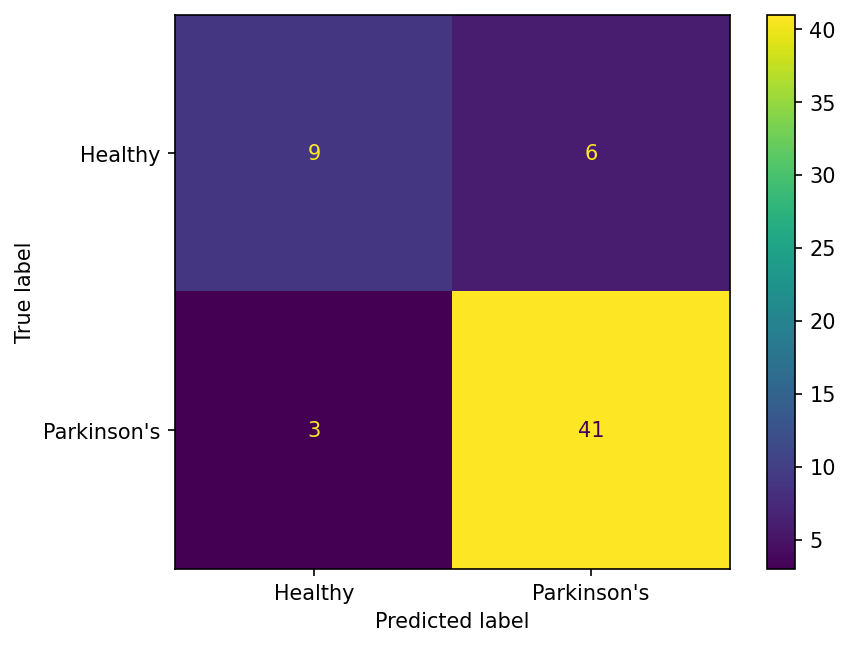

In [12]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=["Healthy", "Parkinson's"])

The above metrics already give us an idea of how well our model predicts Parkinson's.

But in the case of imbalanced datasets like ours (i.e. not an equal amount of Parkinson's vs healthy cases), these metrics alone are insufficient to evaluate the model's performance. Instead, we need to use other metrics that can provide us with a better picture of how the model is performing.

One such metric is the Matthews Correlation Coefficient (MCC). The MCC is a correlation coefficient that measures the quality of binary classifications, including those in imbalanced datasets. It takes into account true and false positives and negatives and returns a value between -1 and 1. An MCC score of 1 represents a perfect prediction, while a score of -1 represents a completely wrong prediction. A score of 0 means the model makes predictions at random.

Mathematically, the MCC is defined as follows:

$MCC = \frac{(TP × TN) - (FP × FN)} {\sqrt{(TP + FP) × (TP + FN) × (TN + FP) × (TN + FN)}}$

where TP, TN, FP, and FN are the number of true positives, true negatives, false positives, and false negatives, respectively. By taking all of these factors into account, MCC provides a more balanced measure of the model's performance on an imbalanced dataset.

In [13]:
# Calculate MCC on test data
mcc = matthews_corrcoef(y_test, y_pred)

print("MCC on test data:", mcc)

MCC on test data: 0.5753016196555826


This section first used the trained logistic regression model to make predictions on the test data, using `model.predict(X_test)`.

Finally, the Matthews Correlation Coefficient (MCC) was calculated on the test data using `matthews_corrcoef(y_test, predicted_labels)`. This is a measure of how well the model performs at predicting both the positive and negative classes, taking into account any class imbalance. A perfect MCC score is 1, while a score of -1 indicates that the model is completely wrong, and a score of 0 is random guessing. You can read more about MCC [here](https://towardsdatascience.com/the-best-classification-metric-youve-never-heard-of-the-matthews-correlation-coefficient-3bf50a2f3e9a).

Our score of ~0.58 is so-so, can you do better?

# Section 8: Your turn!

You can find all sorts of models in `sklearn`. See [here](https://scikit-learn.org/stable/supervised_learning.html) for a list of them.

Now it's your turn! Try to create a new model and see how your performance fares! A boilerplate code is below, but feel free to play around with it how you see fit.

In [14]:
# Select which model to import
from sklearn.XXX import XXX
# e.g. from sklearn.linear model import Lasso

# Create an instance of the model
model = XXX() # e.g. Lasso()

# Fit the model to the training data
model.fit(X_train, y_train)


# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the model's performance using the MCC score
mcc = matthews_corrcoef(y_test, y_pred)
print("MCC Score:", mcc)

ModuleNotFoundError: No module named 'sklearn.XXX'